# Indian E-Commerce Data

This project utilizes a basic dataset from an anonymous e-commerce company located in India. Three csv files are combined into a three table database file using DB Browser for SQLite. SQL queries are run in Jupyter via ipython-sql and query results are saved as variables for further analysis and visualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3 as sql

## Data Cleaning

Before I create the database file that I'll use in this project, I need do some cleaning operations. Two of the csv files included in the dataset contain date information that is not in the correct format for use in SQLite queries. I need to change the date formats so that I can utilize SQLite's strftime function. The date formats need to look like this: YYYY-MM-DD

In [2]:
df = pd.read_csv('List of Orders.csv')

In [3]:
df.head()

,Order ID,Order Date,CustomerName,State,City
0,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad
1,B-25602,01-04-2018,Pearl,Maharashtra,Pune
2,B-25603,03-04-2018,Jahan,Madhya Pradesh,Bhopal
3,B-25604,03-04-2018,Divsha,Rajasthan,Jaipur
4,B-25605,05-04-2018,Kasheen,West Bengal,Kolkata


In [4]:
df['Order Date'] = df['Order Date'].str[-4:] + "-" + df['Order Date'].str[3:5] + "-" + df['Order Date'].str[:2]

In [5]:
df.head()

,Order ID,Order Date,CustomerName,State,City
0,B-25601,2018-04-01,Bharat,Gujarat,Ahmedabad
1,B-25602,2018-04-01,Pearl,Maharashtra,Pune
2,B-25603,2018-04-03,Jahan,Madhya Pradesh,Bhopal
3,B-25604,2018-04-03,Divsha,Rajasthan,Jaipur
4,B-25605,2018-04-05,Kasheen,West Bengal,Kolkata


In [6]:
df.to_csv('list_of_orders_clean.csv', index = False)

In [7]:
targets = pd.read_csv('Sales target.csv')

In [8]:
targets.head()

,Month of Order Date,Category,Target
0,Apr-18,Furniture,10400.0
1,May-18,Furniture,10500.0
2,Jun-18,Furniture,10600.0
3,Jul-18,Furniture,10800.0
4,Aug-18,Furniture,10900.0


In [9]:
months = {'Jan':'01',
         'Feb':'02',
         'Mar':'03',
         'Apr':'04',
         'May':'05',
         'Jun':'06',
         'Jul':'07',
         'Aug':'08',
         'Sep':'09',
         'Oct':'10',
         'Nov':'11',
         'Dec':'12'}

In [10]:
targets['Month of Order Date'] = targets['Month of Order Date'].replace(months, regex=True)

In [11]:
targets['Month of Order Date'] = "20" + targets['Month of Order Date'].str[-2:] + "-" + targets['Month of Order Date'].str[:3] + "01"

In [12]:
targets.head()

,Month of Order Date,Category,Target
0,2018-04-01,Furniture,10400.0
1,2018-05-01,Furniture,10500.0
2,2018-06-01,Furniture,10600.0
3,2018-07-01,Furniture,10800.0
4,2018-08-01,Furniture,10900.0


In [13]:
targets.to_csv('sales_target_clean.csv', index=False)

## Create Database and Connect to Database File

Now that I have the date formats ready for SQLite, the csv files are combined into a database file externally using DB Browser for SQLite, and I can load SQL into the notebook and connect to the database file I've created

In [14]:
%load_ext sql

In [15]:
%sql sqlite:////users/john/desktop/indian_ecommerce_data/list_of_orders.db

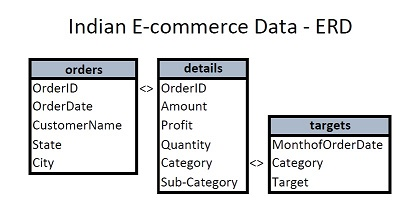

**What is the average order total?**

In [16]:
%%sql

SELECT avg(order_total) as avg_order
FROM
    (SELECT SUM(amount) as order_total
    FROM details
    GROUP BY OrderID)sub;

 * sqlite:////users/john/desktop/indian_ecommerce_data/list_of_orders.db
Done.


avg_order
863.004


**How many orders per month on average?**

In [17]:
%%sql

SELECT AVG(order_count) as avg_orders_per_month
FROM
    (SELECT DISTINCT(COUNT(OrderID)) as order_count, strftime("%Y-%m", OrderDate) as date_month
    FROM orders
    GROUP BY strftime("%Y-%m", OrderDate))sub;

 * sqlite:////users/john/desktop/indian_ecommerce_data/list_of_orders.db
Done.


avg_orders_per_month
38.46153846153846


**What is the company's overall margin?**

In [18]:
%%sql

SELECT (profit / revenue) * 100 as margin
FROM
    (SELECT SUM(Amount) as revenue, SUM(Profit) as profit
    FROM details) sub;

 * sqlite:////users/john/desktop/indian_ecommerce_data/list_of_orders.db
Done.


margin
5.551538579195461


This is a very low profit margin. I'll review margin by category to see if this might provide any insight on why margins are so low.

**What is the company's margin by category?**

In [19]:
%%sql

SELECT category as category, (profit / revenue) * 100 as margin
FROM
    (SELECT category as category, SUM(Amount) as revenue, SUM(Profit) as profit
    FROM details
    GROUP BY category)sub;

 * sqlite:////users/john/desktop/indian_ecommerce_data/list_of_orders.db
Done.


category,margin
Clothing,8.027816531707106
Electronics,6.349724990469967
Furniture,1.8068736682366076


We see that the furniture category has the lowest margin. I'll review the sub-categories in detail to gain more insight.

**What is the margin and proportion of each sub-category?**

In [20]:
%%sql

WITH T1 AS
	(SELECT "Sub-Category" as sub_cat, SUM(Amount) as sub_sales
	FROM details
	GROUP BY "Sub-Category"),
T2 AS
	(SELECT sub_cat as sub_cat, (profit / revenue) * 100 as margin
	FROM
		(SELECT "sub-category" as sub_cat, SUM(Amount) as revenue, SUM(Profit) as profit
		FROM details
		GROUP BY "sub-category")sub),
T3 AS
	(SELECT SUM(Amount) as sales
	FROM details)

SELECT T1.sub_cat as sub_category, T1.sub_sales as sales, t2.margin as margin, (t1.sub_sales / t3.sales) * 100 as proportion_of_sales
FROM T1
JOIN T2
ON T1.sub_cat = T2.sub_cat
JOIN T3;

 * sqlite:////users/john/desktop/indian_ecommerce_data/list_of_orders.db
Done.


sub_category,sales,margin,proportion_of_sales
Accessories,21728.0,16.37978645066274,5.035434366468753
Bookcases,56861.0,8.596401751639963,13.177459200652605
Chairs,34222.0,1.6860499094149963,7.93090182664275
Electronic Games,39168.0,-3.1556372549019605,9.07713058108653
Furnishings,13484.0,6.259270246217739,3.1248986099716802
Hankerchief,14608.0,14.361993428258488,3.385384077014707
Kurti,3361.0,5.38530199345433,0.7789071661313273
Leggings,2106.0,12.345679012345679,0.48806262775143566
Phones,46119.0,4.785446345324053,10.688015351029659
Printers,58252.0,10.238275080683925,13.499821553550156


It looks like 15% of sales (tables and electronic games) actually have a negative margin. This has a significant impact on overall margin.

**What do we see in total sales over time?**

In [21]:
%%sql
SELECT strftime("%Y-%m", OrderDate) as month, SUM(Amount) as sales
FROM orders
JOIN details
ON orders.OrderID = details.OrderID
GROUP BY strftime("%Y-%m", OrderDate)

 * sqlite:////users/john/desktop/indian_ecommerce_data/list_of_orders.db
Done.


month,sales
2018-04,32726.0
2018-05,28545.0
2018-06,23658.0
2018-07,12966.0
2018-08,30899.0
2018-09,26628.0
2018-10,31615.0
2018-11,48086.0
2018-12,37579.0
2019-01,61439.0


In [22]:
sales_time = _

In [23]:
sales_time = pd.DataFrame(sales_time)

In [24]:
sales_time.rename(columns = {0:'date',1:'sales'}, inplace=True)

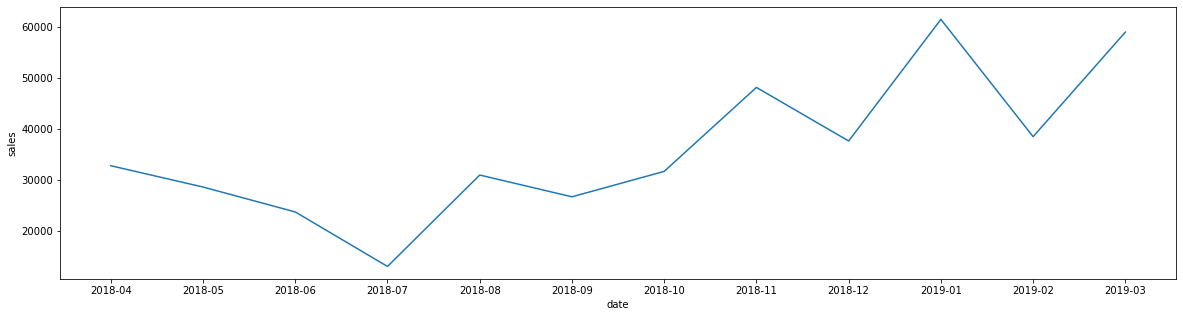

In [25]:
plt.figure(figsize = (20,5))
ticks = sales_time['date'].values
sb.lineplot(data=sales_time, x = 'date', y = 'sales', sort = False)
plt.xticks(ticks);

We see upward growth through to the end of the dataset with the exception of a dip in July of 2018.